In [440]:
import pandas as pd
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator
import numpy as np
import math
import os
from collections import defaultdict
import bisect

In [441]:
plot_defaults = list()

# original alignment
plot_defaults.append({"x_col": "Novel Junctions", "y_col":"Reference Junctions", \
    "xlabel": r'Novel Junctions ($\times10^{3}$)', "ylabel": r'Reference Junctions ($\times10^{3}$)', \
    "treatment": "original", "color": "black"}
    )

plot_defaults.append({"x_col": "EASTR Novel Junctions", "y_col": "EASTR Reference Junctions", \
    "xlabel": r'Novel Junctions ($\times10^{3}$)', "ylabel": r'Reference Junctions ($\times10^{3}$)', \
    "treatment": "EASTR", "color": "red"}
    )
# EASTR alignment
category_name = "Aligner"

out_basedir = "/ccb/salz8-3/rhu16/EASTR/EASTR_analyses/junction_plots"

# plot specs
scale_x = 1000
scale_y = 1000

# plot specs for any category_name other than non-EASTR vs EASTR (see plot_defaults for that)
plot_subgroups = {'hisat':{'label':'HISAT2', 'marker':'o'}, 'star':{'label':'STAR', 'marker':'^'}}
#color_groups = treatments
#colors = ["black", "red"]
#marker_groups = ["hisat", "star"]
#marker_labels = ["HISAT2", "STAR"]
#markers = ["o", "^"]


In [442]:
experiment=3

In [443]:
if experiment == 1:
    dataset = "lieber_sra"

    junction_file = os.path.join("/ccb/salz2/shinder/projects/EASTR_tests2", dataset, "eastr_juncs_alns_summary.tsv")
    outdir = os.path.join(out_basedir, dataset)

    info_list = list()
    info_list.append({"targets": ["SRR10689481","SRR10689483","SRR10689487"], "target_labels": ["SRR10689481","SRR10689483","SRR10689487"], "comparison": "riboZ", "title": "Prenatal DLPFC: poly(A)"})
    info_list.append({"targets": ["SRR10689480","SRR10689482","SRR10689486"], "target_labels": ["SRR10689480","SRR10689482","SRR10689486"], "comparison": "polyA", "title": "Prenatal DLPFC: ribo-minus"})


In [444]:
if experiment == 2:
    dataset = "arabidopsis_methylation"

    junction_file = os.path.join("/ccb/salz2/shinder/projects/EASTR_tests2", dataset, "eastr_juncs_alns_summary.tsv")
    outdir = os.path.join(out_basedir, dataset)

    info_list = list()
    info_list.append({"targets": ["SRR14056780", "SRR14056781", "SRR14056782"], "target_labels": ["SRR14056780", "SRR14056781", "SRR14056782"], "comparison": "mddcc", "title": "Arabidopsis: mddcc-mutant"})
    info_list.append({"targets": ["SRR16596898", "SRR16596899", "SRR16596900"], "target_labels": ["SRR16596898", "SRR16596899", "SRR16596900"], "comparison": "wt", "title": "Arabidopsis: wild-type"})


In [445]:
if experiment == 3:
    dataset = "maize_pollen"

    junction_file = os.path.join("/ccb/salz2/shinder/projects/EASTR_tests2", dataset, "eastr_juncs_alns_summary.tsv")
    outdir = os.path.join(out_basedir, dataset)


    info_list = list()
    info_list.append({"targets": ["SRR3091548", "SRR3091717", "SRR3094513"], "target_labels": ["SRR3091548", "SRR3091717", "SRR3094513"], "comparison": "pollen", "title": "Maize: pollen"})

In [446]:
if experiment == 4:
    dataset = "maize_leaves"

    junction_file = os.path.join("/ccb/salz2/shinder/projects/EASTR_tests2", dataset, "eastr_juncs_alns_summary.tsv")
    outdir = os.path.join(out_basedir, dataset)


    info_list = list()
    info_list.append({"targets": ["SRR10095075", "SRR10095076", "SRR10095077"], "target_labels": ["SRR10095075", "SRR10095076", "SRR10095077"], "comparison": "leaf_infected", "title": "Maize: lower leaf (infected)"})


In [447]:
if not os.path.exists(outdir):
    os.makedirs(outdir)

junction_stats = pd.read_csv(junction_file, sep='\t')
junction_stats["EASTR Reference Junctions"] = junction_stats["Reference Junctions"] - junction_stats["Removed Reference Junctions"]
junction_stats["EASTR Novel Junctions"] = junction_stats["Novel Junctions"] - junction_stats["Removed Novel Junctions"]
junction_stats["sampleID"] = junction_stats["SRR ID"]

In [448]:
def match_group(treatment_str=str, groups=list()):
    found = False
    match_idx = None
    for i in range(0, len(groups)):
        if treatment_str.find(groups[i]) >= 0:
            if found:
                raise Exception("more than one group matched by this string-finding function")
            found = True
            match_idx = i
    return match_idx

def baseround(x, base=1):
    return int(base * round(float(x)/base))

def basefloor(x, base=1):
    return base * math.floor(float(x)/base)

def baseceil(x, base=1):
    return base * math.ceil(float(x)/base)

def space_labels(vals, tick_len, min_val=0, margin_count=1):
    return np.arange(max(basefloor(min(vals), base=tick_len) - tick_len*margin_count, 0), baseceil(max(vals), base=tick_len) + tick_len*margin_count, tick_len)

def space_whole_labels(values, tick_magnitude=5, ticks=5, pad_factor=0):
    diff = ( max(values) - min(values) )
    pad = diff*pad_factor
    #width = pad + diff + pad # left pad + difference between min, max + right pad
    tick_spacing = max(baseround(diff/ticks, base=tick_magnitude), tick_magnitude)

    # leftmost and rightmost grid (floor to left align, making it closer to the origin if necessary)
    leftmost = basefloor( min(values) - pad, base=tick_magnitude) #- tick_magnitude
    rightmost = baseceil( max(values) + pad, base=tick_magnitude) + tick_spacing
    
    #print(leftmost)
    #print(np.arange(math.floor(min(values) - pad)-1, math.ceil(max(values) + pad)+1, tick_spacing))
    return np.arange(leftmost, rightmost, tick_spacing)

# set axis range based on "data," a dict of category_name -> values (e.g.: all HISAT2 data; all STAR data), and a built-in spacing rule
# ignore_keys: keys in the vals dict to ignore
def set_axis_limits(data:dict, scale=2, pad=0.1, ignore_keys=list()):
    largest_range = 0
    all_values = list() # sorted list of all values
    for key, vals in data.items():
        if key not in ignore_keys:
            largest_range = max(largest_range, max(vals) - min(vals))
            for val in vals:
                bisect.insort(all_values, val)
    midpoint = (all_values[-1] + all_values[0])/2
    
    bound_left = midpoint - largest_range*scale*(1+pad)
    bound_right = midpoint + largest_range*scale*(1+pad)

    return [bound_left, bound_right]

# make figure with subplots, each subplot being the junction stats of one sample (with multiple data points/conditions)
#   labeled/stratified by plot_subgroups and stats_df[category_name]
def subplot_targets(stats_df, info, plot_defaults, plot_subgroups, category_name):
    targets = info["targets"]
    target_labels = info["target_labels"]
    title = info["title"]

    # get counts for reference-matching and novel junctions
    fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(40, 10),gridspec_kw={'wspace':0.1,'hspace':0.2})
    #fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(40, 10),gridspec_kw={'wspace':0.07,'hspace':0.2})


    # to help scale the subplots:
    # get max relative difference in the x direction (specific to EASTR analysis), within a "category_name," across all target samples
    #   e.g.:
    #       category_name="Aligner": HISAT2, STAR
    #       treatment (plot_defaults[<some index>][treatment]): original, EASTR
    #       This section will: Find max(|EASTR - original|), considering every sampleID x category_name

    # iterate target samples
    max_rel_diff_x = 0
    #max_rel_diff_y = 0
    for i in range(0, len(targets)):
        sampleID = targets[i]
        sampleLabel = target_labels[i]
        sample_stats = stats_df.loc[stats_df["sampleID"] == sampleID]
        # iterate categories
        for idx in range(0, len(sample_stats)):
            sample_stat = sample_stats.iloc[[idx]]
            for i in range(0, len(plot_defaults)):
                for j in range(i+1, len(plot_defaults)):
                    x1 = sample_stat[plot_defaults[i]["x_col"]].values[0]/scale_x
                    x2 = sample_stat[plot_defaults[j]["x_col"]].values[0]/scale_x
                    #y1 = sample_stat[plot_defaults[i]["y_col"]].values[0]/scale_y
                    #y2 = sample_stat[plot_defaults[j]["y_col"]].values[0]/scale_y
                    
                    max_rel_diff_x = max(max_rel_diff_x, abs(x2 - x1)/x1)
                    #max_rel_diff_y = max(max_rel_diff_y, abs(y2 - y1))



    # plot each sample, for all treatments
    key_all = "_all_"

    axes_idx = 0
    for i in range(0, len(targets)):
        sampleID = targets[i]
        sampleLabel = target_labels[i]
        #print(sample + "__________")
        #plt.figure(figsize=(10, 8), dpi=80)
        x_data = defaultdict(list) # all x
        y_data = defaultdict(list) # all y
        sample_stats = stats_df.loc[stats_df["sampleID"] == sampleID]

        local_max_x = 0 # maximum relative x difference for this sample

        for idx in range(0, len(sample_stats)):
            sample_stat = sample_stats.iloc[[idx]]
            for i in range(0, len(plot_defaults)):
                # plot
                subgroup = sample_stat[category_name].values[0]
                treatment_group = plot_defaults[i]["treatment"]
                x_val = sample_stat[plot_defaults[i]["x_col"]].values[0]/scale_x
                x_data[key_all].append(x_val)
                x_data[subgroup].append(x_val)
                y_val = sample_stat[plot_defaults[i]["y_col"]].values[0]/scale_y
                y_data[key_all].append(y_val)
                y_data[subgroup].append(y_val)
                axes[axes_idx].scatter(x_val, y_val, \
                    color=plot_defaults[i]["color"], marker=plot_subgroups[subgroup]['marker'], \
                    s=500, \
                    label = plot_subgroups[subgroup]['label'] + ", " + treatment_group)
                axes[axes_idx].tick_params(axis='both', which='major', labelsize=28)
                axes[axes_idx].set_title("  " + sampleLabel, fontsize=40, y=0.85, loc='left')
                #params = {'font.size': 100}
                #plt.rcParams.update(params)

                # get relative difference (if iterable)
                for j in range(i+1, len(plot_defaults)):
                    x1 = sample_stat[plot_defaults[i]["x_col"]].values[0]/scale_x
                    x2 = sample_stat[plot_defaults[j]["x_col"]].values[0]/scale_x
                    
                    local_max_x = max(local_max_x, abs(x2 - x1)/x1)

        #axes[axes_idx].xaxis.set_major_locator(AutoLocator())
        x_tick_len = 20
        xticks = space_labels(vals=x_data[key_all], tick_len=x_tick_len, margin_count=10)
        axes[axes_idx].set_xticks(xticks) #.locator_params(axis='x', nbins=5)
        
        y_tick_len = 1
        yticks = space_labels(vals=y_data[key_all], tick_len=y_tick_len, margin_count=10)
        axes[axes_idx].set_yticks(yticks)
        #print(space_whole_labels(x_data[key_all]))
        #axes[axes_idx].set_yticks(space_whole_labels(y_data[key_all], tick_magnitude=1, pad_factor=0.1))
        #axes[axes_idx].locator_params(axis='x', nbins=5)
        #axes[axes_idx].locator_params(axis='y', nbins=6)
            
        x_pad = 0.2
        y_pad = 0.22

        #x_diff = 0.12 * max(x_data[subgroup]) * 5 * min(1.5, max((0.09/local_max_x)**3, 0.5)) # scaling scheme to highlight relative difference
        print((max_rel_diff_x, local_max_x))
        #print(min(2, max((0.09/local_max_x)**3, 0.5)))
        #x_diff = max( max(x_data[key_all]) - min(x_data[key_all]), 0.05/x_pad)
        y_diff = max( max(y_data[key_all]) - min(y_data[key_all]), 0.05/y_pad)

        ##axes[axes_idx].set_xlim([min(xticks) - pad*x_diff, max(xticks) + pad*x_diff])
        ##axes[axes_idx].set_ylim([min(yticks) - pad*y_diff, max(yticks) + pad*y_diff])
        #axes[axes_idx].set_xlim([min(x_data[key_all]) - x_pad*x_diff, max(x_data[key_all]) + x_pad*x_diff])
        axes[axes_idx].set_ylim([min(y_data[key_all]) - y_pad*y_diff, max(y_data[key_all]) + y_pad*y_diff])

        mid_x = (min(x_data[key_all]) + max(x_data[key_all]))/2
        x_diff = 0.3*max(x_data[key_all])
        axes[axes_idx].set_xlim([mid_x - x_diff, mid_x + x_diff])
        
        #plt.autoscale()
        #axes.set_xlabel(xlabel)
        #axes.set_ylabel(ylabel)
        #plt.tight_layout()

        #plt.savefig(os.path.join(outdir, sampleID + "_" + y_col + "_vs_" + x_col + ".png"))
        axes_idx += 1

    fig.suptitle(title, fontsize=40)
    fig.supxlabel(plot_defaults[0]["xlabel"], fontsize=32)
    fig.supylabel(plot_defaults[0]["ylabel"], fontsize=32)
    plt.subplots_adjust(top=0.8, left=0.08, bottom=0.18)
    plt.margins(0.2)
    plt.legend(bbox_to_anchor=(1, -0.3), fontsize=20)


(0.07386895475819036, 0.06452091918179453)
(0.07386895475819036, 0.07035192563081008)
(0.07386895475819036, 0.07386895475819036)


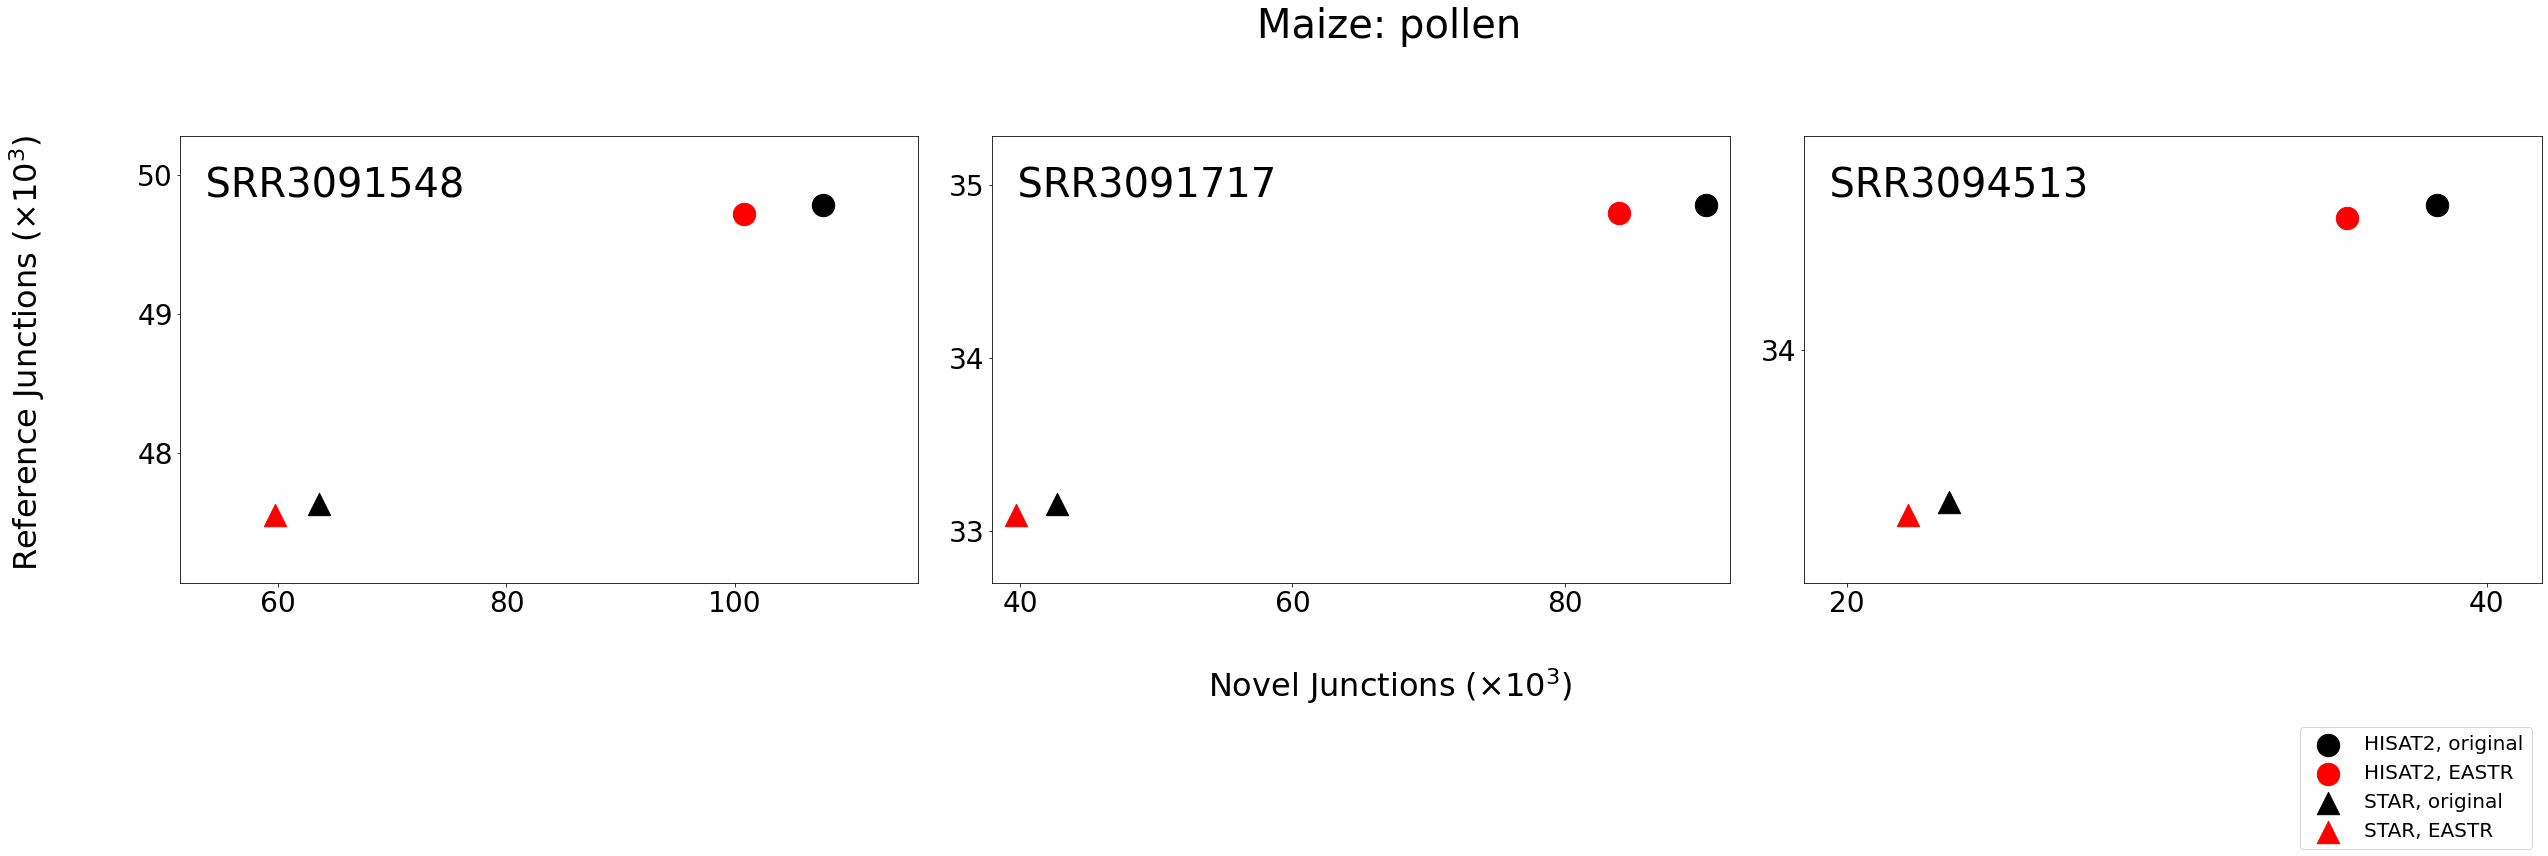

In [449]:

for i in range(0, len(info_list)):
    subplot_targets(stats_df=junction_stats, info=info_list[i], plot_defaults=plot_defaults, plot_subgroups=plot_subgroups, category_name=category_name)
    plt.savefig(os.path.join(outdir, info_list[i]["comparison"] + ".png"))
    plt.show()
    plt.close()

In [450]:
plot_defaults

[{'x_col': 'Novel Junctions',
  'y_col': 'Reference Junctions',
  'xlabel': 'Novel Junctions ($\\times10^{3}$)',
  'ylabel': 'Reference Junctions ($\\times10^{3}$)',
  'treatment': 'original',
  'color': 'black'},
 {'x_col': 'EASTR Novel Junctions',
  'y_col': 'EASTR Reference Junctions',
  'xlabel': 'Novel Junctions ($\\times10^{3}$)',
  'ylabel': 'Reference Junctions ($\\times10^{3}$)',
  'treatment': 'EASTR',
  'color': 'red'}]